This is a notebook to explore the techniques used in the paper "Physics-assisted machine learning for THz time-domain spectroscopy: sensing leaf wetness" which can be found at the following link: https://www.nature.com/articles/s41598-024-57161-4#Sec7


In [22]:
import math
import os
import pickle
from datetime import datetime
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
import optuna
from scipy.signal import correlate
from scipy.signal.windows import tukey
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
data_path = "Data/Ex-Vivo/final_data.pkl"
data_folder_path = "Data/Ex-Vivo/"

# Load individual files and create the final data object
files = os.listdir("Data/Ex-Vivo/")

if "READ_ME.txt" in files:
    files.remove("READ_ME.txt")

data = []

for file in tqdm(files, desc="Loading files"):
    with open(os.path.join(data_folder_path, file), 'rb') as f:
        data.append(pickle.load(f))

for d in data:
    timestamp = d['time']
    d['date'] = datetime.fromisoformat(timestamp)

data = sorted(data, key=lambda x: x['date'])

# performing basic preprocessing

# Fixing labeling errors
data[51]['samplematrix'] = 'sample 7 PBS'
data[51]['conc'] = 0.0

data[52]['samplematrix'] = 'sample 8 g/PBS'
data[52]['conc'] = 2.5

data[53]['samplematrix'] = 'sample 6 g/PBS'
data[53]['conc'] = 2.5


# Fixing issue with sample ids due to multiple days
for d in data:
    d['samplematrix_fixed'] = d['samplematrix']

for d in data[37:]:
    values = d['samplematrix'].split()
    if len(values) > 1:
        id = int(values[1])
        new_id = id+18
        new_samplematrix = values[0] + " " + str(new_id) + " " + values[2]
        d['samplematrix_fixed'] = new_samplematrix


# Removing air and NC as these are irrelevant for our purpose
data = [d for d in data if not d['samplematrix_fixed'] == 'air']

ids_to_remove = []

for d in data:
    values = d['samplematrix_fixed'].split()
    if values[2] == 'NC':
        ids_to_remove.append(values[1])

data = [d for d in data if not d['samplematrix_fixed'].split()[1] in ids_to_remove]

Loading files: 100%|██████████| 95/95 [00:25<00:00,  3.66it/s]


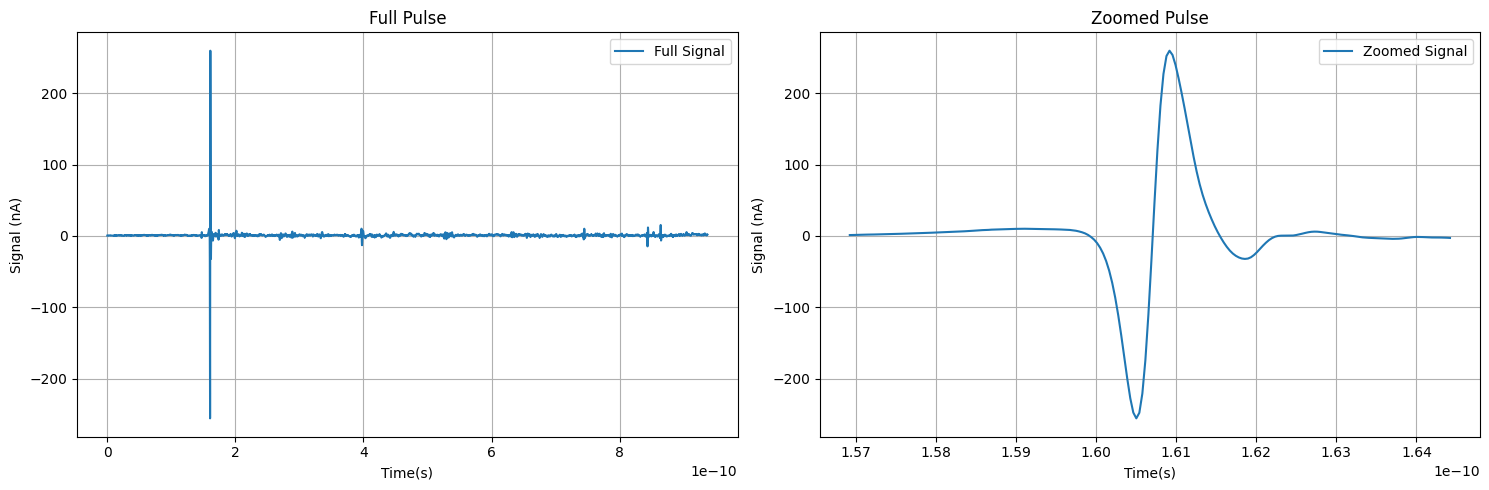

In [3]:
# Plotting signals
x = data[4]['scan'][0]['forward_scan']['time']
y = data[4]['scan'][0]['forward_scan']['signal']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 100
zoom_end = middle_index + 100

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Shape of the data
print("Data Shape")
print("Number of samples: ", len(data))
print("Number of scans per sample: ", len(data[0]['scan']))
print("Number of time points per scan: ", len(data[0]['scan'][0]['forward_scan']['time']))



Data Shape
Number of samples:  88
Number of scans per sample:  10
Number of time points per scan:  24900


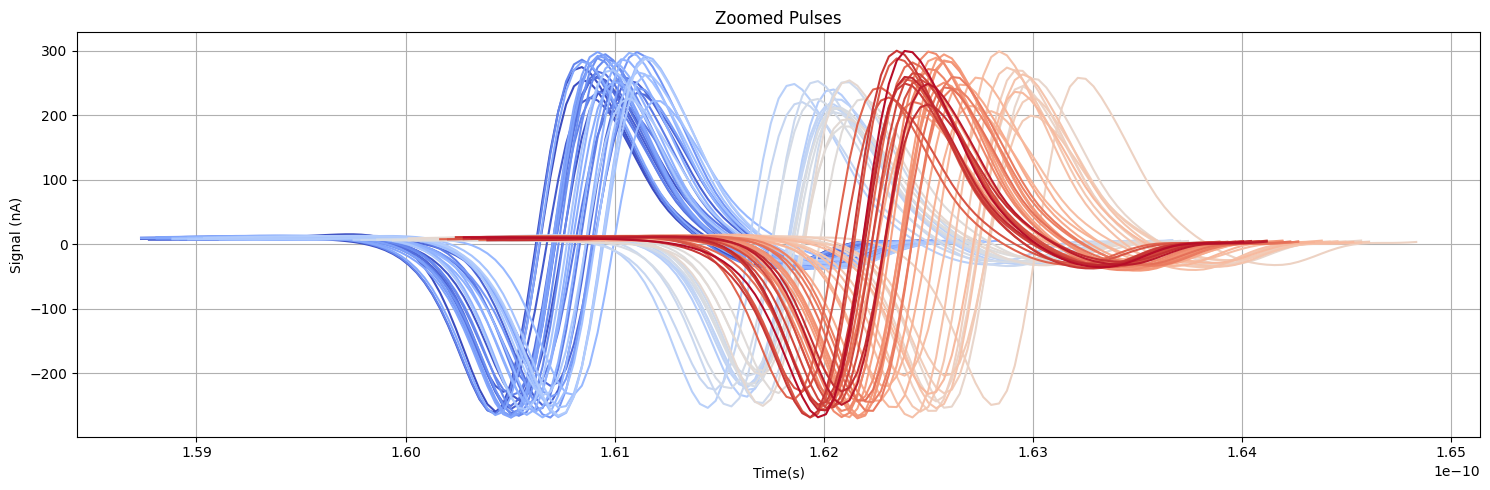

In [5]:
# Plotting multiple signals onto same time axis zoomed in
# the pulses are colored as a gradient from blue to red to show the progression of the pulses

plt.figure(figsize=(15, 5))

number_of_pulses = len(data)

for i in range(0, number_of_pulses):
    x = data[i]['scan'][0]['forward_scan']['time']
    y = data[i]['scan'][0]['forward_scan']['signal']

    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index + max_index) / 2)
    zoom_start = middle_index - 50
    zoom_end = middle_index + 50

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()





TODO: These measurements come from TopticaSmart which is unstable in time axis. We need to find a way to correct for this shift before applying the polynomial function!
Try the same method from the paper, and then try other methods. 

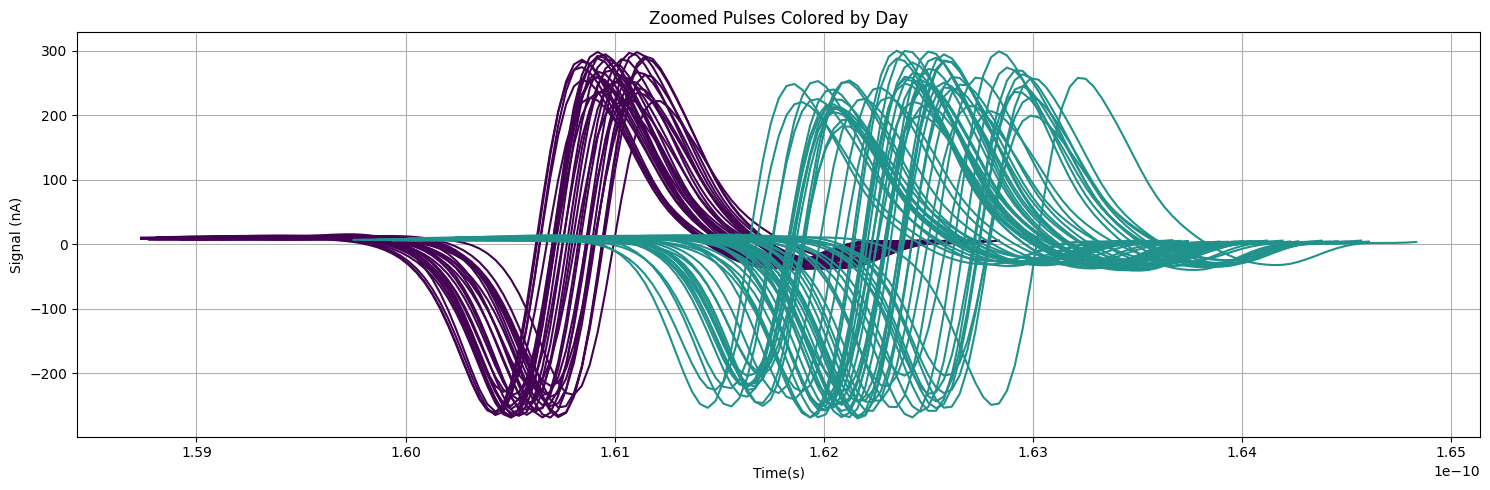

In [6]:
plt.figure(figsize=(15, 5))

number_of_pulses = len(data)


unique_days = sorted(set(point['date'].day for point in data))
day_to_color = {day: plt.cm.viridis(i / len(unique_days)) for i, day in enumerate(unique_days)}

for i in range(0, number_of_pulses):
    x = data[i]['scan'][0]['forward_scan']['time']
    y = data[i]['scan'][0]['forward_scan']['signal']

    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index + max_index) / 2)
    zoom_start = middle_index - 50
    zoom_end = middle_index + 50

    day = data[i]['date'].day
    color = day_to_color[day]

    plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label=f'Pulse {i} (Day {day})', color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulses Colored by Day")
plt.grid(True)
plt.tight_layout()
plt.show()


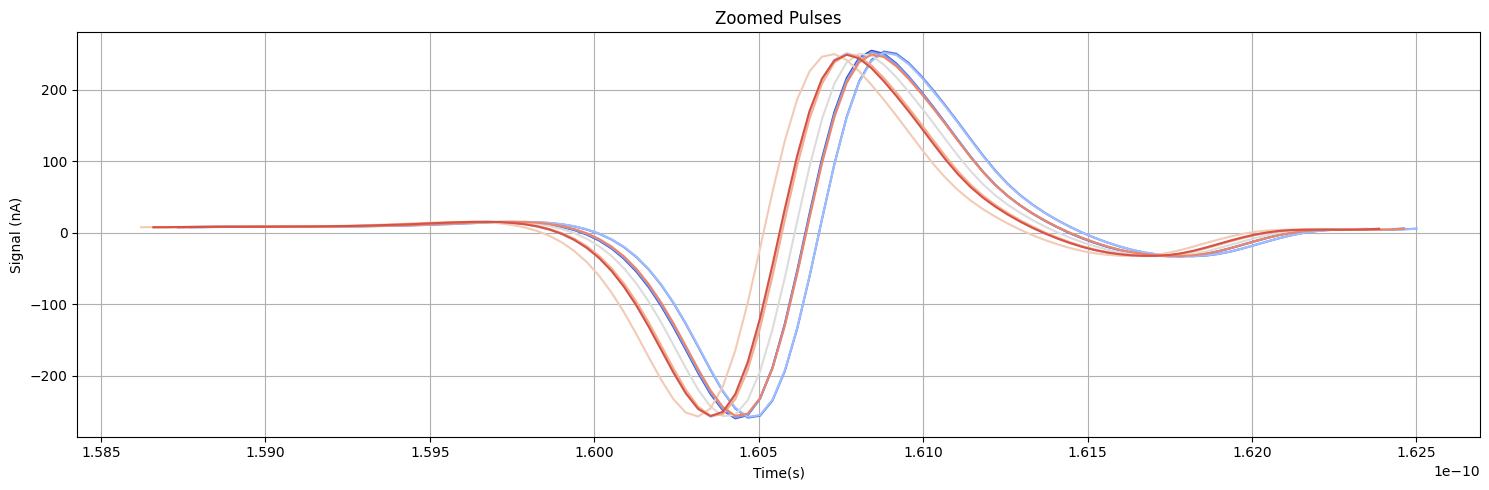

In [7]:
# Plotting multiple signals onto same time axis zoomed in
# the pulses are colored as a gradient from blue to red to show the progression of the pulses

plt.figure(figsize=(15, 5))

number_of_pulses = len(data[0]['scan'])

for i in range(0, number_of_pulses):
    x = data[0]['scan'][i]['forward_scan']['time']
    y = data[0]['scan'][i]['forward_scan']['signal']

    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index + max_index) / 2)
    zoom_start = middle_index - 50
    zoom_end = middle_index + 50

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()





observations so far: 
1) Data is randomly time shifted which shows the time instability of the topticaSmart system
2) The time shift tends to group based on which day the data was sampled
3) The time shift is not only across different samples, but also across multiple pulses on same samples, although to a lesser degree

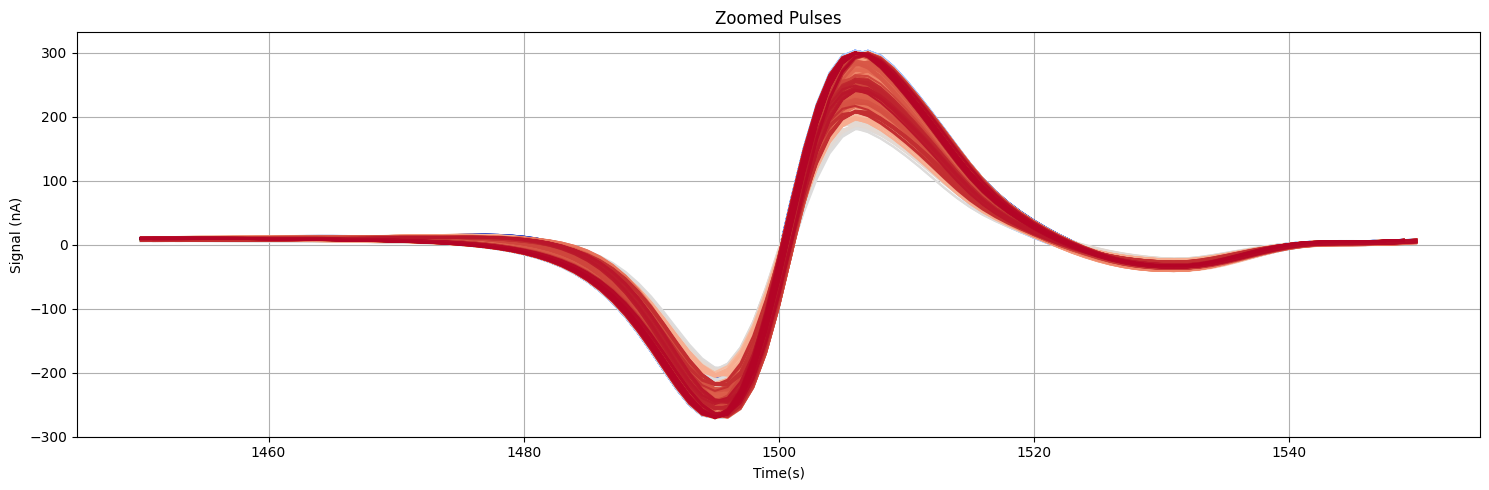

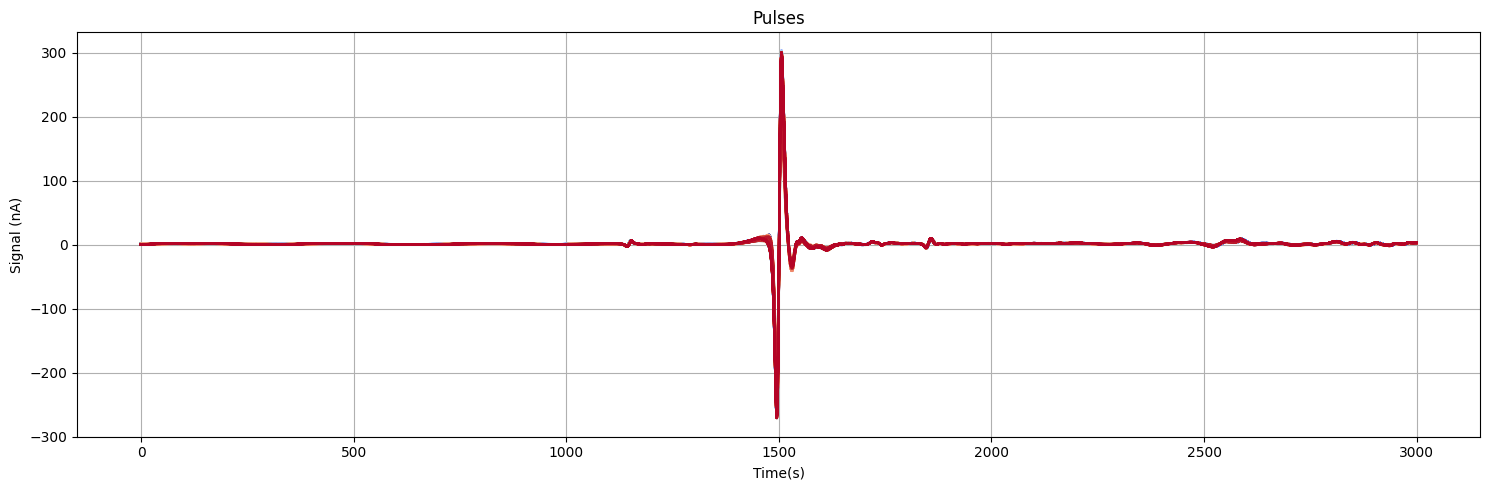

In [8]:
# Choosing the first pulse as the reference pulse
reference_pulse = data[0]['scan'][0]['forward_scan']['signal']
min_index = np.argmin(reference_pulse)
max_index = np.argmax(reference_pulse)
middle_index = math.floor((min_index+max_index)/2)

window_size = 1500
window_start = middle_index - window_size
window_end = middle_index + window_size

# Function to find the shift using cross-correlation
def find_shift(reference, pulse):
    correlation = correlate(pulse, reference)
    shift = correlation.argmax() - (len(pulse) - 1)
    return shift

# Aligning the pulses
aligned_data = []
for pulse in data:
    for scan in pulse['scan']:
        signal = scan['forward_scan']['signal']
        shift = find_shift(reference_pulse, signal)
        aligned_pulse = np.roll(signal, -shift)
        aligned_pulse = aligned_pulse[window_start:window_end] # Cropping the signal to the window so all pulses have the same length
        scan['aligned'] = aligned_pulse
        aligned_data.append(aligned_pulse)
    for ref in pulse['ref']:
        signal = ref['forward_scan']['signal']
        shift = find_shift(reference_pulse, signal)
        aligned_pulse = np.roll(signal, -shift)
        aligned_pulse = aligned_pulse[window_start:window_end]
        ref['aligned'] = aligned_pulse
        aligned_data.append(aligned_pulse)
    
    pulse['avg_pulse_aligned'] = np.mean([scan['aligned'] for scan in pulse['scan']], axis=0)
    pulse['avg_ref_aligned'] = np.mean([ref['aligned'] for ref in pulse['ref']], axis=0)



plt.figure(figsize=(15, 5))

number_of_pulses = len(aligned_data)

for i in range(0, number_of_pulses):
    x = np.arange(len(aligned_data[i]))
    y = aligned_data[i]

    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index + max_index) / 2)
    zoom_start = middle_index - 50
    zoom_end = middle_index + 50

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()

# plotting without zoom

plt.figure(figsize=(15, 5))

number_of_pulses = len(aligned_data)

for i in range(0, number_of_pulses):
    x = np.arange(len(aligned_data[i]))
    y = aligned_data[i]

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x, y, label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()



TODO:
- Average the 10 air ref pulses to create on stable noise baseline
- Average the 10 pulses on the sample
- Subtract the sample average from air average to remove noise
- continue with the papers method

In [9]:
# Using the averaged reference pulse to remove baseline noise from the average pulse

for pulse in data:
    pulse['avg_pulse_aligned_cleaned'] = pulse['avg_pulse_aligned'] - pulse['avg_ref_aligned']

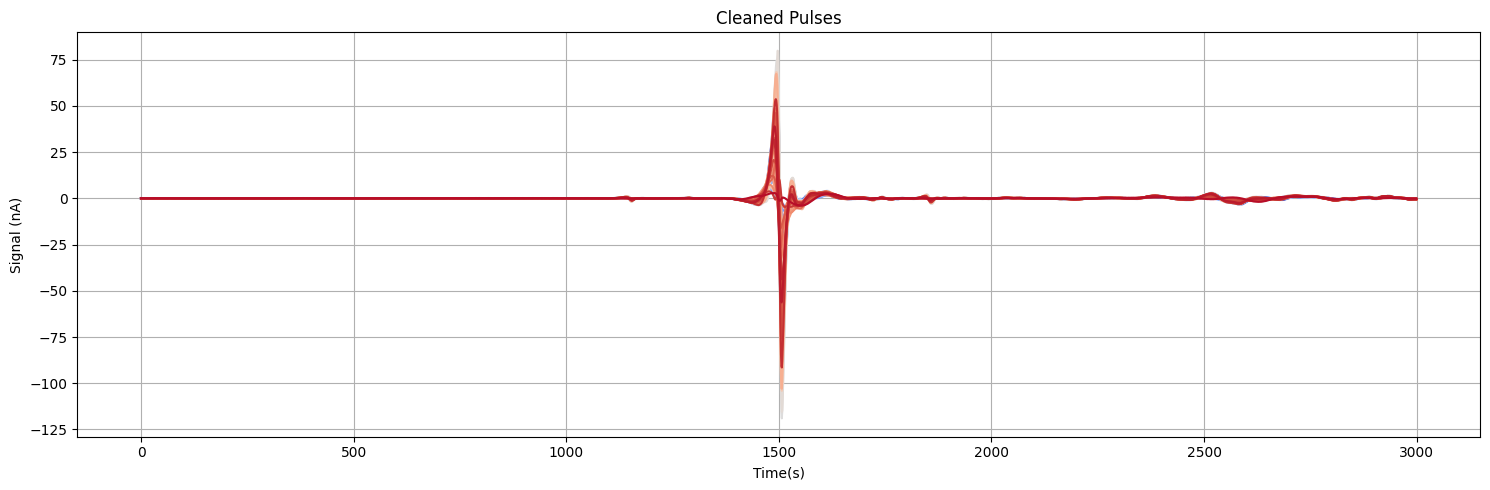

In [10]:
# plotting without zoom

plt.figure(figsize=(15, 5))

number_of_pulses = len(data)

for i in range(0, number_of_pulses):
    x = np.arange(len(data[i]['avg_pulse_aligned_cleaned']))
    y = data[i]['avg_pulse_aligned_cleaned']

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x, y, label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Cleaned Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# using the bare pulses to remove sample noise from the treated pulse and to isolate the effect of the treatment

bare_data = [d for d in data if 'bare' in d['samplematrix_fixed']]
treated_data = [d for d in data if not 'bare' in d['samplematrix_fixed']]
final_data = []
labels = []
for i, d in enumerate(treated_data):
    treated = treated_data[i]
    bare = bare_data[i]

    final_data.append(treated['avg_pulse_aligned_cleaned'] - bare['avg_pulse_aligned_cleaned'])
    labels.append(treated['samplematrix_fixed'].split()[2])

final_data = np.asarray(final_data)
labels = np.asarray(labels)

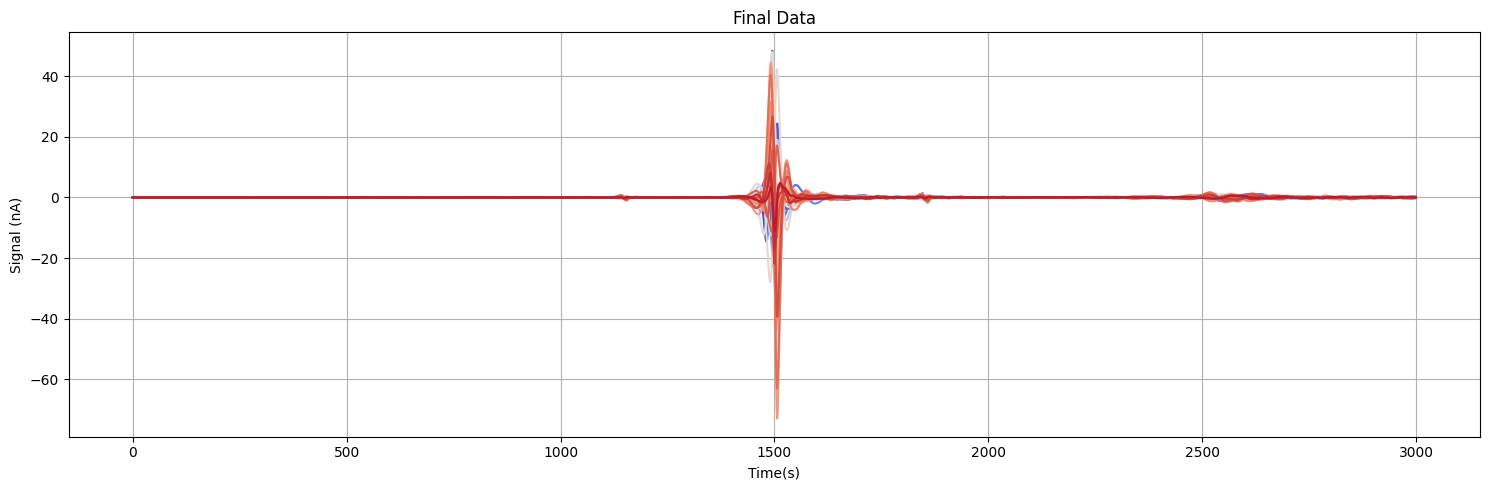

In [12]:
# plotting the final data

plt.figure(figsize=(15, 5))

number_of_pulses = len(final_data)

for i in range(0, number_of_pulses):
    x = np.arange(len(final_data[i]))
    y = final_data[i]

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x, y, label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Data")
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# applying tukey window to the final data

tukey_window_size = 1000
tukey_alpha = .8

final_tukey_data = []

for pulse in final_data:
    window_start = len(pulse) // 2 - tukey_window_size
    window_end = len(pulse) // 2 + tukey_window_size

    window = tukey(window_end-window_start, alpha = tukey_alpha)
    tukey_window = pulse[window_start: window_end] * window

    new_pulse = np.zeros(len(pulse), dtype=float)
    new_pulse[window_start: window_end] = tukey_window
    final_tukey_data.append(new_pulse)

final_tukey_data = np.asarray(final_tukey_data)

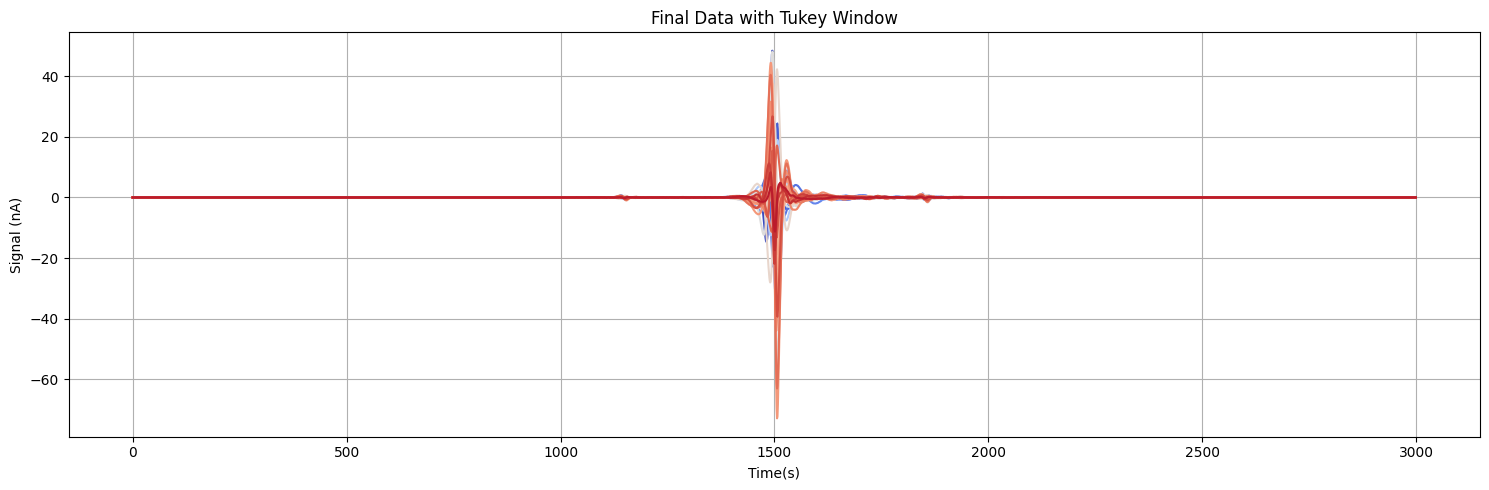

In [14]:
# plotting the final data after applying the tukey window

plt.figure(figsize=(15, 5))

number_of_pulses = len(final_tukey_data)

for i in range(0, number_of_pulses):
    x = np.arange(len(final_tukey_data[i]))
    y = final_tukey_data[i]

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x, y, label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Data with Tukey Window")
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
print(final_tukey_data.shape)
print(labels.shape)

(44, 3000)
(44,)


In [16]:
# Fitting polynomial to extract features
# Degree of the polynomial
degree = 15

polynomial_coefficients = []

for pulse in final_tukey_data:
    x = np.arange(len(pulse))
    y = pulse 
    
    coeffs = np.polyfit(x, y, degree)
    polynomial_coefficients.append(coeffs)


polynomial_coefficients = np.array(polynomial_coefficients)

print(polynomial_coefficients.shape)

(44, 16)


In [17]:
# printing unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"{label}: {count}")


PBS: 22
g/PBS: 22


In [18]:
X = polynomial_coefficients
y = labels




The strategy:
1) we have 44 datapoints
2) First reserve some points (e.g. 4) for evaluating the very final model. These points must remain completely unseen and not used in the training process in any way. Not even in cross validation
3) Take the 40 remaining points and do k=4 fold cross validation. This is the outer loop. this creates D1 = (train_1, test_1), D2 = (train_2, test_2) etc.
4) For each outer loop, create a nested/inner loop by splitting further using k-fold cross validation. so train_1 becomes (train_1_1, val_1_1), and (train_1_2, val_1_2) etc.
5) For each inner training set, do feature selection (permutation ranking): train_1_1 -> feature selection -> selected featured based on 1_1
6) For each inner training and validation set, then do hyper parameter tuning. train_1_1 + val_1_1 + selected features -> parameter tuning -> best params based on train 1_1
7) average all best params from the inner training sets. this results in best params based on train_1. Also 'Average' selected features across inner loops, by counting the number of times a feature was selected
8) use these averaged results on the training set from upper loop, and evaluate it on the upper test set
9) This will result in 4 final models each evaluated on a test set
10) you can combine these 4 into a single model by once again averaging the hyperparameters, and then training on the entire test set.
11) finally take this last single model and evaluate on the 4 unseen data points from the beginning to get an unbiased evaluation.






In [19]:
print(f"Number of total datapoints: {len(y)}")

# Reserving 4 datapoints for the final evaluation
X_train = X[:-4]
y_train = y[:-4]
X_test = X[-4:]
y_test = y[-4:]

# printing the number of datapoints in the training and testing sets
print(f"Number of training datapoints: {len(y_train)}")
print(f"Number of testing datapoints: {len(y_test)}")

# checking that the reserved data points are from different samples and equal classes
print(f"Classes in the reserved datapoints: {y_test}")

Number of total datapoints: 44
Number of training datapoints: 40
Number of testing datapoints: 4
Classes in the reserved datapoints: ['g/PBS' 'PBS' 'g/PBS' 'PBS']


In [32]:
k_outer = 4
k_inner = 5

outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=42)

accuracies = []
final_params = []
final_features = []

def process_inner_fold(train_inner_indicies, test_inner_indicies, X_train_outer, y_train_outer):
    X_train_inner, X_test_inner = X_train_outer[train_inner_indicies], X_train_outer[test_inner_indicies]
    y_train_inner, y_test_inner = y_train_outer[train_inner_indicies], y_train_outer[test_inner_indicies]

    model_inner = RandomForestClassifier(n_estimators=100, random_state=42)
    model_inner.fit(X_train_inner, y_train_inner)

    # Feature selection using permutation importance
    perm_importance = permutation_importance(model_inner, X_train_inner, y_train_inner, n_repeats=10, random_state=42)
    importances = perm_importance.importances_mean
    indices = np.argsort(importances)[::-1]
    threshold = 0.01  # Defining a threshold for feature importance
    important_indices = indices[importances[indices] > threshold]
    # Selecting important features
    X_train_inner_reduced = X_train_inner[:, important_indices]
    X_test_inner_reduced = X_test_inner[:, important_indices]

    feature_counts = np.zeros(X_train_outer.shape[1])
    feature_counts[important_indices] += 1

    # Hyperparameter tuning using optuna and the reduced features
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 400)
        max_depth = trial.suggest_int('max_depth', 5, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
        min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.5)

        model_for_tuning = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            criterion=criterion,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42,
        )

        model_for_tuning.fit(X_train_inner_reduced, y_train_inner)
        y_pred = model_for_tuning.predict(X_test_inner_reduced)
        accuracy = accuracy_score(y_test_inner, y_pred)
        return accuracy

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=20)

    best_params = study.best_params
    return feature_counts, best_params

for train_outer_indicies, test_outer_indicies in outer_cv.split(X_train, y_train):
    X_train_outer, X_test_outer = X_train[train_outer_indicies], X_train[test_outer_indicies]
    y_train_outer, y_test_outer = y_train[train_outer_indicies], y_train[test_outer_indicies]

    inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=42)

    results = Parallel(n_jobs=-1)(delayed(process_inner_fold)(train_inner_indicies, test_inner_indicies, X_train_outer, y_train_outer) for train_inner_indicies, test_inner_indicies in inner_cv.split(X_train_outer, y_train_outer))

    # Combining results from parallel processing
    feature_counts = np.sum([result[0] for result in results], axis=0)
    best_params_from_inner = [result[1] for result in results]

    # Filtering out features based on count threshold
    threshold = 2
    important_features = np.where(feature_counts >= threshold)[0]
    X_train_outer_reduced = X_train_outer[:, important_features]
    X_test_outer_reduced = X_test_outer[:, important_features]

    # Averaging the best hyperparameters from inner folds
    best_params = {}
    for key in best_params_from_inner[0].keys():
        if isinstance(best_params_from_inner[0][key], str) or isinstance(best_params_from_inner[0][key], bool):
            best_params[key] = max(set([params[key] for params in best_params_from_inner]), key=[params[key] for params in best_params_from_inner].count)
        elif isinstance(best_params_from_inner[0][key], int):
            best_params[key] = int(np.round(np.mean([params[key] for params in best_params_from_inner])))
        else:
            best_params[key] = np.mean([params[key] for params in best_params_from_inner])

    final_params.append(best_params)
    final_features.append(feature_counts)

    # Training the model on the outer fold
    model_outer = RandomForestClassifier(random_state=42, **best_params)
    model_outer.fit(X_train_outer_reduced, y_train_outer)
    y_pred_outer = model_outer.predict(X_test_outer_reduced)
    accuracy_outer = accuracy_score(y_test_outer, y_pred_outer)
    accuracies.append(accuracy_outer)

# Averaging the final accuracies
final_accuracy = np.mean(accuracies)
print(f"Final estimated accuracy by averaging: {final_accuracy}")

# Filtering out features based on count threshold
threshold = 2
final_important_features = np.where(np.sum(final_features, axis=0) >= threshold)[0]
X_train_reduced = X_train[:, final_important_features]
X_test_reduced = X_test[:, final_important_features]

# Averaging the final hyperparameters
final_hyperparameters = {}
for key in final_params[0].keys():
    if isinstance(final_params[0][key], str) or isinstance(final_params[0][key], bool):
        final_hyperparameters[key] = max(set([params[key] for params in final_params]), key=[params[key] for params in final_params].count)
    elif isinstance(final_params[0][key], int):
        final_hyperparameters[key] = int(np.round(np.mean([params[key] for params in final_params])))
    else:
        final_hyperparameters[key] = np.mean([params[key] for params in final_params])

print(f"Final hyperparameters: {final_hyperparameters}")

# Training the final model on the entire training set
model_final = RandomForestClassifier(random_state=42, **final_hyperparameters)
model_final.fit(X_train_reduced, y_train)

# Evaluating the final model on the test set
y_pred_test = model_final.predict(X_test_reduced)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"Final accuracy on the test set: {accuracy_test}")


Final estimated accuracy by averaging: 0.4
Final hyperparameters: {'n_estimators': 188, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'min_weight_fraction_leaf': 0.23491109119404188, 'max_leaf_nodes': 53, 'min_impurity_decrease': 0.19556490920812836}
Final accuracy on the test set: 0.5


In [33]:
print(final_important_features)

[12 13 14 15]
